In [1]:
import omniglot_train_few_shot_experiement as ot
import task_generator_no_args as tg
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

In [2]:
import sys
print(f'python : {sys.version}')
print(f'pytorch : {torch.__version__}')

python : 3.8.3 (default, May 17 2020, 18:15:42) 
[GCC 10.1.0]
pytorch : 1.4.0


In [3]:
FEATURE_DIM = 64  
RELATION_DIM = 8  
CLASS_NUM = 5  
SAMPLE_NUM_PER_CLASS = 5  
BATCH_NUM_PER_CLASS = 15  
EPISODE = 1000000  
TEST_EPISODE = 1000  
LEARNING_RATE = 0.001  
HIDDEN_UNIT = 10 

# Test just 1 iteration to know how it works

In [4]:
# * Step 1: init data folders
print("init data folders")

# * Init character folders for dataset construction
metatrain_character_folders, metatest_character_folders = tg.omniglot_character_folders()

init data folders


In [5]:
# * Step 2: init neural networks
print("init neural networks")

feature_encoder = ot.CNNEncoder()
relation_network = ot.RelationNetwork(FEATURE_DIM, RELATION_DIM)


feature_encoder.apply(ot.weights_init)
relation_network.apply(ot.weights_init)

feature_encoder.to(device)
relation_network.to(device)
    
feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(), lr=LEARNING_RATE)
#feature_encoder_scheduler = ot.StepLR(feature_encoder_optim, step_size=100000, gamma=0.5)

relation_network_optim = torch.optim.Adam(relation_network.parameters(), lr=LEARNING_RATE)
#relation_network_scheduler = ot.StepLR(relation_network_optim, step_size=100000, gamma=0.5)

if os.path.exists(str("./models/omniglot_feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")):
    feature_encoder.load_state_dict(torch.load(str("./models/omniglot_feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")))
    print("load feature encoder success")
if os.path.exists(str("./models/omniglot_relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")):
    relation_network.load_state_dict(torch.load(str("./models/omniglot_relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")))
    print("load relation network success")

init neural networks


In [6]:
episode = 1
#feature_encoder_scheduler.step(episode)
#relation_network_scheduler.step(episode)

# * init dataset
# * sample_dataloader is to obtain previous samples for compare
# * batch_dataloader is to batch samples for training
degrees = random.choice([0, 90, 180, 270])
task = tg.OmniglotTask(metatrain_character_folders, CLASS_NUM, SAMPLE_NUM_PER_CLASS, BATCH_NUM_PER_CLASS)
sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
batch_dataloader = tg.get_data_loader(task, num_per_class=BATCH_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)

# * sample datas
samples, sample_labels = next(iter(sample_dataloader))  # sample_dataloader.__iter__().next()
batches, batch_labels = next(iter(batch_dataloader))  # batch_dataloader.__iter__().next()

In [7]:
from sklearn.datasets import load_iris
from sklearn import tree
X, y = load_iris(return_X_y=True)
print(X.shape)
print(samples.shape)

print(y.shape)
print(sample_labels.shape)

(150, 4)
torch.Size([25, 1, 28, 28])
(150,)
torch.Size([25])


In [8]:
X = np.array(samples)
X = X.reshape(25, -1)
print(X.shape)
Y = np.array(sample_labels)

(25, 784)


In [9]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [10]:
clf.predict(X)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4])

In [11]:
test = np.array(batches)
print(test.shape)
test = test.reshape(75, -1)
print(test.shape)

(75, 1, 28, 28)
(75, 784)


In [12]:
clf.predict(test)

array([1, 3, 3, 3, 3, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 0,
       1, 0, 1, 4, 4, 3, 0, 2, 0, 0, 2, 3, 0, 3, 2, 1, 0, 2, 2, 0, 1, 0,
       3, 4, 2, 1, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 3, 3, 1, 1, 0, 2, 0, 1,
       1, 3, 2, 2, 0, 1, 0, 3, 1])

In [13]:
print(batch_labels)

tensor([1, 2, 3, 0, 0, 1, 4, 2, 4, 1, 0, 1, 0, 1, 1, 1, 0, 3, 1, 3, 3, 2, 3, 4,
        3, 4, 0, 2, 2, 4, 4, 2, 3, 3, 2, 0, 0, 1, 4, 4, 3, 2, 0, 3, 3, 4, 2, 0,
        2, 0, 3, 2, 4, 0, 0, 1, 2, 3, 3, 0, 4, 1, 2, 4, 2, 1, 1, 4, 2, 4, 0, 1,
        4, 3, 1])


In [14]:
from sklearn.metrics import accuracy_score
predict = clf.predict(test)
true = np.array(batch_labels)
assert predict.shape == true.shape

accuracy_score(predict, true)

0.37333333333333335

tensor(0)


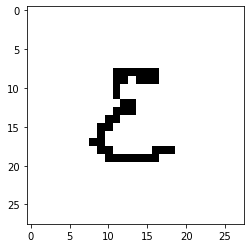

In [15]:
print(sample_labels[0])
plt.imshow(samples[0].reshape(28, 28), cmap='gray')

In [16]:
samples, sample_labels = samples.to(device), sample_labels.to(device)
batches, batch_labels = batches.to(device), batch_labels.to(device)

In [17]:
print(samples.shape)
print(sample_labels)

torch.Size([25, 1, 28, 28])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4], device='cuda:0')


In [18]:
print(batches.shape)
print(batch_labels)

torch.Size([75, 1, 28, 28])
tensor([1, 2, 3, 0, 0, 1, 4, 2, 4, 1, 0, 1, 0, 1, 1, 1, 0, 3, 1, 3, 3, 2, 3, 4,
        3, 4, 0, 2, 2, 4, 4, 2, 3, 3, 2, 0, 0, 1, 4, 4, 3, 2, 0, 3, 3, 4, 2, 0,
        2, 0, 3, 2, 4, 0, 0, 1, 2, 3, 3, 0, 4, 1, 2, 4, 2, 1, 1, 4, 2, 4, 0, 1,
        4, 3, 1], device='cuda:0')


In [19]:
sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
test_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)

In [20]:
sample_images, sample_labels = next(iter(sample_dataloader))
test_images, test_labels = next(iter(test_dataloader))

In [21]:
print(sample_images.shape)
print(sample_labels)
print(test_images.shape)
print(test_labels)

torch.Size([25, 1, 28, 28])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])
torch.Size([25, 1, 28, 28])
tensor([0, 2, 4, 1, 3, 1, 3, 2, 3, 4, 4, 3, 1, 2, 4, 1, 4, 2, 0, 0, 0, 2, 0, 3,
        1])


In [22]:
# * calculates features
linear, sample_features = feature_encoder(samples)
print(sample_features.shape)

torch.Size([25, 64, 5, 5])


In [23]:
one_hot_labels = torch.zeros(SAMPLE_NUM_PER_CLASS * CLASS_NUM, CLASS_NUM).scatter_(1, sample_labels.view(-1, 1), 1)
print(one_hot_labels)

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])


In [24]:
print(nn.MSELoss()(one_hot_labels.to(device), linear.view(-1, CLASS_NUM)))

tensor(0.7738, device='cuda:0', grad_fn=<MeanBackward0>)


In [25]:
sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, 5, 5)
print(sample_features.shape)

torch.Size([5, 5, 64, 5, 5])


In [26]:
sample_features_temp = sample_features.reshape(25, -1)
print(sample_features_temp.shape)

torch.Size([25, 1600])


In [27]:
print(sample_features[0])

tensor([[[[0.0000e+00, 1.0318e+00, 6.6294e-01, 7.8039e-01, 9.5128e-01],
          [1.9493e-03, 0.0000e+00, 5.3378e-01, 0.0000e+00, 0.0000e+00],
          [6.8132e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0285e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5523e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2598e-02, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.3721e-01, 0.0000e+00, 0.0000e+00],
          [7.7468e-01, 1.4093e+00, 5.0608e-01, 3.3169e-01, 0.0000e+00]],

         [[2.5836e-01, 1.5689e-01, 1.4243e+00, 1.2697e+00, 1.0691e+00],
          [0.0000e+00, 7.3928e-01, 3.3199e-01, 0.0000e+00, 3.6572e-01],
          [1.5265e+00, 3.1951e-01, 2.5892e+00, 1.1257e+00, 3.3447e-01],
          [0.0000e+00, 8.1803e-01, 1.9363e-01, 4.8775e-01, 5

In [28]:
print(sample_features_temp[0])
print(sample_features_temp.reshape(5,5,64,5,5))

tensor([0.0000, 1.0318, 0.6629,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([[[[[0.0000e+00, 1.0318e+00, 6.6294e-01, 7.8039e-01, 9.5128e-01],
           [1.9493e-03, 0.0000e+00, 5.3378e-01, 0.0000e+00, 0.0000e+00],
           [6.8132e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0285e-01],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5523e-01],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2598e-02, 0.0000e+00]],

          [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 2.3721e-01, 0.0000e+00, 0.0000e+00],
           [7.7468e-01, 1.4093e+00, 5.0608e-01, 3.3169e-01, 0.0000e+00]],

          [[2.5836e-01, 1.5689e-01, 1.4243e+00, 1.2697e+00, 1.0691e+00],
           [0.0000e+00, 7.3928e-01, 3.3199e-01, 0.0000e+00, 3.6572e-01],
       

In [29]:
batch_linear, batch_features = feature_encoder(batches)
print(batch_features.shape)

torch.Size([75, 64, 5, 5])


In [30]:
sample_temp = np.array(sample_features.detach().cpu())
sample_temp = sample_temp.reshape(25, -1)
sample_temp_labels = np.array(sample_labels.detach().cpu())
print(sample_temp.shape)
print(sample_temp_labels.shape)

clf.fit(sample_temp, sample_temp_labels)

batch_temp = np.array(batch_features.detach().cpu())
batch_temp = batch_temp.reshape(batch_temp.shape[0], -1)
print(batch_temp.shape)
batch_temp_label = np.array(batch_labels.detach().cpu())

(25, 1600)
(25,)
(75, 1600)


In [31]:
'''
predict = clf.predict(test)
true = np.array(batch_labels)
assert predict.shape == true.shape

accuracy_score(predict, true)
'''

predict = clf.predict(batch_temp)
batch_temp_label = batch_temp_label.reshape(-1)
assert predict.shape == batch_temp_label.shape, f"{predict.shape}, {batch_temp_label.shape}"

accuracy_score(predict, batch_temp_label)

0.22666666666666666

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf2 = RandomForestClassifier(n_estimators=120, random_state=1)
clf2.fit(sample_temp, sample_temp_labels)

predict2 = clf2.predict(batch_temp)
batch_temp_label = batch_temp_label.reshape(-1)
assert predict2.shape == batch_temp_label.shape, f"{predict.shape}, {batch_temp_label.shape}"

print(clf2.predict_proba(batch_temp))
accuracy_score(predict2, batch_temp_label)

[[0.14166667 0.28333333 0.20833333 0.175      0.19166667]
 [0.20833333 0.2        0.19166667 0.25       0.15      ]
 [0.15833333 0.2        0.275      0.225      0.14166667]
 [0.18333333 0.175      0.2        0.18333333 0.25833333]
 [0.14166667 0.23333333 0.28333333 0.175      0.16666667]
 [0.19166667 0.34166667 0.13333333 0.20833333 0.125     ]
 [0.175      0.20833333 0.25833333 0.13333333 0.225     ]
 [0.11666667 0.3        0.19166667 0.26666667 0.125     ]
 [0.23333333 0.16666667 0.14166667 0.175      0.28333333]
 [0.225      0.26666667 0.21666667 0.15       0.14166667]
 [0.16666667 0.28333333 0.21666667 0.18333333 0.15      ]
 [0.10833333 0.25833333 0.25       0.175      0.20833333]
 [0.16666667 0.325      0.18333333 0.08333333 0.24166667]
 [0.175      0.225      0.26666667 0.225      0.10833333]
 [0.18333333 0.14166667 0.175      0.09166667 0.40833333]
 [0.10833333 0.40833333 0.1        0.25833333 0.125     ]
 [0.16666667 0.125      0.19166667 0.225      0.29166667]
 [0.175      0

0.37333333333333335

In [52]:
from sklearn.metrics import classification_report
print(classification_report(batch_temp_label, predict2))

precision    recall  f1-score   support

           0       0.23      0.47      0.31        15
           1       0.53      0.53      0.53        15
           2       0.23      0.20      0.21        15
           3       0.22      0.13      0.17        15
           4       0.12      0.07      0.09        15

    accuracy                           0.28        75
   macro avg       0.27      0.28      0.26        75
weighted avg       0.27      0.28      0.26        75



In [44]:
print(clf.predict_proba(batch_temp))

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0.

In [41]:
_, predicted = torch.max(batch_linear, 1)
print(predicted)
correct = (predicted == batch_labels).sum().item()
print(correct/len(batch_labels))

tensor([3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 2, 3, 3, 3, 3,
        3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 1, 3], device='cuda:0')
0.14666666666666667


In [27]:
'''
>>> q = torch.tensor([[[1,2,3], [4,5,6]], [[7, 8, 9], [10, 11, 12]]])
>>> q
tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])
>>> q.shape
torch.Size([2, 2, 3])
>>> torch.sum(q, 1)
tensor([[ 5,  7,  9],
        [17, 19, 21]])
>>> torch.sum(q, 1).squeeze(1)
tensor([[ 5,  7,  9],
        [17, 19, 21]])
'''        
sample_features = torch.sum(sample_features, 1)
print(sample_features.shape)

torch.Size([5, 64, 5, 5])


In [28]:
sample_features = sample_features.squeeze(1)
print(sample_features.shape)

torch.Size([5, 64, 5, 5])


In [29]:
batch_features, _ = feature_encoder(batches)
print(batch_features.shape)

torch.Size([75, 64, 5, 5])


In [32]:
predict = clf.predict(batch_temp)

assert predict.shape == batch_temp_label.shape

accuracy_score(predict, batch_temp_label)

ValueError: Number of features of the model must match the input. Model n_features is 320 and input n_features is 1600 

In [79]:
# * calculate relations
# * each batch sample link to every samples to calculate relations
# * to form a 100 * 128 matrix for relation network
sample_features_ext = sample_features.unsqueeze(0)
print(sample_features_ext.shape)

sample_features_ext = sample_features_ext.repeat(BATCH_NUM_PER_CLASS * CLASS_NUM, 1, 1, 1, 1)
print(sample_features_ext.shape)

torch.Size([1, 5, 64, 5, 5])
torch.Size([75, 5, 64, 5, 5])


In [80]:
batch_features_ext = batch_features.unsqueeze(0)
print(batch_features_ext.shape)

batch_features_ext = batch_features_ext.repeat(CLASS_NUM, 1, 1, 1, 1)
print(batch_features_ext.shape)

torch.Size([1, 75, 64, 5, 5])
torch.Size([5, 75, 64, 5, 5])


In [81]:
batch_features_ext = torch.transpose(batch_features_ext, 0, 1)
print(batch_features_ext.shape)

torch.Size([75, 5, 64, 5, 5])


In [25]:
relation_pairs = torch.cat((sample_features_ext, batch_features_ext), 2)
print(relation_pairs.shape)

relation_pairs = relation_pairs.view(-1, FEATURE_DIM * 2, 5, 5)
print(relation_pairs.shape)

torch.Size([75, 5, 128, 5, 5])
torch.Size([375, 128, 5, 5])


In [26]:
relations, features = relation_network(relation_pairs)
print(relations.shape)

relations = relations.view(-1, CLASS_NUM)
print(relations.shape)

torch.Size([375, 1])
torch.Size([75, 5])


In [27]:
print(relations)
print(torch.softmax(relations, dim=-1))

tensor([[0.7109, 0.7105, 0.7113, 0.7105, 0.7108],
        [0.7107, 0.7104, 0.7111, 0.7105, 0.7108],
        [0.7109, 0.7106, 0.7113, 0.7108, 0.7109],
        [0.7111, 0.7107, 0.7116, 0.7109, 0.7107],
        [0.7111, 0.7109, 0.7117, 0.7109, 0.7110],
        [0.7110, 0.7108, 0.7114, 0.7107, 0.7107],
        [0.7114, 0.7108, 0.7117, 0.7109, 0.7115],
        [0.7113, 0.7110, 0.7115, 0.7109, 0.7112],
        [0.7113, 0.7108, 0.7114, 0.7108, 0.7113],
        [0.7111, 0.7107, 0.7118, 0.7107, 0.7110],
        [0.7111, 0.7107, 0.7119, 0.7108, 0.7110],
        [0.7109, 0.7108, 0.7114, 0.7106, 0.7108],
        [0.7110, 0.7106, 0.7115, 0.7104, 0.7106],
        [0.7111, 0.7107, 0.7114, 0.7108, 0.7108],
        [0.7109, 0.7106, 0.7112, 0.7106, 0.7108],
        [0.7109, 0.7108, 0.7116, 0.7106, 0.7109],
        [0.7113, 0.7107, 0.7118, 0.7107, 0.7108],
        [0.7115, 0.7109, 0.7113, 0.7109, 0.7107],
        [0.7109, 0.7106, 0.7115, 0.7106, 0.7108],
        [0.7112, 0.7110, 0.7117, 0.7110, 0.7109],


In [28]:
print(features.shape)

torch.Size([375, 64, 1, 1])


In [29]:
mse = nn.MSELoss()
one_hot_labels = torch.zeros(BATCH_NUM_PER_CLASS * CLASS_NUM, CLASS_NUM).to(device).scatter_(1, batch_labels.view(-1, 1), 1)
print(one_hot_labels.shape)
print(relations.shape)
loss = mse(relations, one_hot_labels)

torch.Size([75, 5])
torch.Size([75, 5])


In [29]:
print(batch_labels.shape)

torch.Size([75])


In [32]:
print(loss.cpu().detach().numpy())

0.42929226


In [33]:
feature_encoder.zero_grad()
relation_network.zero_grad()

loss.backward()

torch.nn.utils.clip_grad_norm(feature_encoder.parameters(), 0.5)
torch.nn.utils.clip_grad_norm(relation_network.parameters(), 0.5)

feature_encoder_optim.step()
relation_network_optim.step()

In [34]:
print(loss.cpu().detach().numpy())

0.42929226


episode : 10, loss : 0.4160117506980896  
episode : 20, loss : 0.363679438829422  
episode : 30, loss : 0.28375476598739624  

# Test all iterations

In [35]:
print("Training...")

last_accuracy = 0.0
mse = nn.MSELoss()

for episode in range(EPISODE):
    
    #feature_encoder_scheduler.step(episode)
    #relation_network_scheduler.step(episode)
    
    # * init dataset
    # * sample_dataloader is to obtain previous samples for compare
    # * batch_dataloader is to batch samples for training
    degrees = random.choice([0, 90, 180, 270])
    task = tg.OmniglotTask(metatrain_character_folders, CLASS_NUM, SAMPLE_NUM_PER_CLASS, BATCH_NUM_PER_CLASS)
    sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
    batch_dataloader = tg.get_data_loader(task, num_per_class=BATCH_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)
    
    # * sample datas
    # samples, sample_labels = sample_dataloader.__iter__().next()
    # batches, batch_labels = batch_dataloader.__iter__().next()
    
    samples, sample_labels = next(iter(sample_dataloader))
    batches, batch_labels = next(iter(batch_dataloader))
    
    samples, sample_labels = samples.to(device), sample_labels.to(device)
    batches, batch_labels = batches.to(device), batch_labels.to(device)
        
    one_hot_sample_labels = torch.zeros(SAMPLE_NUM_PER_CLASS * CLASS_NUM, CLASS_NUM).to(device).scatter_(1, sample_labels.view(-1, 1), 1)

    # * calculates features
    sample_features, linear = feature_encoder(samples)
    sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, 5, 5)
    sample_features = torch.sum(sample_features, 1).squeeze(1)
    batch_features, _ = feature_encoder(batches)
    
    embedding_loss = mse(linear, one_hot_sample_labels)

    # * calculate relations
    # * each batch sample link to every samples to calculate relations
    # * to form a 100 * 128 matrix for relation network
    sample_features_ext = sample_features.unsqueeze(0).repeat(BATCH_NUM_PER_CLASS * CLASS_NUM, 1, 1, 1, 1)
    batch_features_ext = batch_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
    batch_features_ext = torch.transpose(batch_features_ext, 0, 1)
    
    relation_pairs = torch.cat((sample_features_ext, batch_features_ext), 2).view(-1, FEATURE_DIM * 2, 5, 5)
    relations = relation_network(relation_pairs).view(-1, CLASS_NUM)
    

    one_hot_labels = torch.zeros(BATCH_NUM_PER_CLASS * CLASS_NUM, CLASS_NUM).to(device).scatter_(1, batch_labels.view(-1, 1), 1)
    loss = mse(relations, one_hot_labels)
    loss += embedding_loss

    feature_encoder.zero_grad()
    relation_network.zero_grad()
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm(feature_encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm(relation_network.parameters(), 0.5)
    
    feature_encoder_optim.step()
    relation_network_optim.step()
    
    if (episode + 1) % 100 == 0:
        print(f"episode : {episode+1}, loss : {loss.cpu().detach().numpy()}")
        
    if (episode + 1) % 2500 == 0:
        print("Testing...")
        total_reward = 0
        
        for i in range(TEST_EPISODE):
            degrees = random.choice([0, 90, 180, 270])
            task = tg.OmniglotTask(metatest_character_folders, CLASS_NUM, SAMPLE_NUM_PER_CLASS, SAMPLE_NUM_PER_CLASS)
            sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
            test_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)

            # sample_images, sample_labels = sample_dataloader.__iter__().next()
            # test_images, test_labels = test_dataloader.__iter__().next()            

            sample_images, sample_labels = next(iter(sample_dataloader))
            test_images, test_labels = next(iter(test_dataloader))

            sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
            test_images, test_labels = test_images.to(device), test_labels.to(device)
                
            # * calculate features
            sample_features, _ = feature_encoder(sample_images)
            sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, 5, 5)
            sample_features = torch.sum(sample_features, 1).squeeze(1)
            test_features, _ = feature_encoder(test_images)
            
            # * calculate relations
            # * each batch sample link to every samples to calculate relations
            # * to form a 100x128 matrix for relation network
            
            sample_features_ext = sample_features.unsqueeze(0).repeat(SAMPLE_NUM_PER_CLASS * CLASS_NUM, 1, 1, 1, 1)
            test_features_ext = test_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
            test_features_ext = torch.transpose(test_features_ext, 0, 1)         

            relation_pairs = torch.cat((sample_features_ext, test_features_ext), 2).view(-1, FEATURE_DIM * 2, 5, 5)
            relations = relation_network(relation_pairs).view(-1, CLASS_NUM)
            
            _, predict_labels = torch.max(relations.data, 1)
            
            rewards = [1 if predict_labels[j] == test_labels[j] else 0 for j in range(CLASS_NUM * SAMPLE_NUM_PER_CLASS)]
            total_reward += np.sum(rewards)
            
        test_accuracy = total_reward/1.0/CLASS_NUM/SAMPLE_NUM_PER_CLASS/TEST_EPISODE
        # total_reward / (1.0 * CLASS_NUM * SAMPLE_NUM_PER_CLASS * TEST_EPISODE)
        
        print("test accuracy : ", test_accuracy)
        
        if test_accuracy > last_accuracy:
            # save networks
            torch.save(
                feature_encoder.state_dict(),
                str("./models/omniglot_feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")
            )

            torch.save(
                relation_network.state_dict(),
                str("./models/omniglot_relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")
            )

            print("save networks for episode:", episode)
            last_accuracy = test_accuracy    

Training...
episode : 100, loss : 0.3154416084289551
episode : 200, loss : 0.2484121322631836
episode : 300, loss : 0.2421010285615921
episode : 400, loss : 0.2561458647251129
episode : 500, loss : 0.23913037776947021
episode : 600, loss : 0.2268974781036377
episode : 700, loss : 0.20814134180545807
episode : 800, loss : 0.20158953964710236
episode : 900, loss : 0.2230621874332428
episode : 1000, loss : 0.20491725206375122
episode : 1100, loss : 0.22936466336250305
episode : 1200, loss : 0.22024692595005035
episode : 1300, loss : 0.20556291937828064
episode : 1400, loss : 0.1771606206893921
episode : 1500, loss : 0.17625921964645386
episode : 1600, loss : 0.21023140847682953
episode : 1700, loss : 0.20093770325183868
episode : 1800, loss : 0.2110174596309662
episode : 1900, loss : 0.24598142504692078
episode : 2000, loss : 0.20057158172130585
episode : 2100, loss : 0.20276468992233276
episode : 2200, loss : 0.19725066423416138
episode : 2300, loss : 0.20562830567359924
episode : 2400, 